In [3]:
your_api_key=''

In [2]:
!pip install langchain langchain_core langchain_community langgraph langchain_openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 19.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
  Attempting uninstall: langchain_core
    Foun

In [6]:
from langchain_openai.chat_models import ChatOpenAI

llm=ChatOpenAI(api_key=your_api_key,temperature=0.9)

In [9]:
from os import set_inheritable
from typing_extensions import TypedDict

class State(TypedDict):
  application:str
  experience_level:str
  skill_match:str
  response:str


In [10]:
from langgraph.graph import StateGraph,START,END
workflow=StateGraph(State)

In [11]:
from langchain_core.prompts import ChatPromptTemplate

In [12]:
def categorize_experience(state: State) -> State:
  print("\nCategorizing the experience level of candidate : ")
  prompt = ChatPromptTemplate.from_template(
      "Based on the following job application, categorize the candidate as 'Entry-level', 'Mid-level' or 'Senior-level'"
      "Application : {application}"
  )
  chain = prompt | llm
  experience_level = chain.invoke({"application": state["application"]}).content
  print(f"Experience Level : {experience_level}")
  return {"experience_level" : experience_level}

def assess_skillset(state: State) -> State:
  print("\nAssessing the skillset of candidate : ")
  prompt = ChatPromptTemplate.from_template(
      "Based on the job application for a Python Developer, assess the candidate's skillset"
      "Respond with either 'Match' or 'No Match'"
      "Application : {application}"
  )
  chain = prompt | llm
  skill_match = chain.invoke({"application": state["application"]}).content
  print(f"Skill Match : {skill_match}")
  return {"skill_match" : skill_match}

def schedule_hr_interview(state: State) -> State:
  print("\nScheduling the interview : ")
  return {"response" : "Candidate has been shortlisted for an HR interview."}

def escalate_to_recruiter(state: State) -> State:
  print("Escalating to recruiter")
  return {"response" : "Candidate has senior-level experience but doesn't match job skills."}

def reject_application(state: State) -> State:
  print("Sending rejecting email")
  return {"response" : "Candidate doesn't meet JD and has been rejected."}

In [13]:
workflow.add_node("categorize_experience", categorize_experience)
workflow.add_node("assess_skillset", assess_skillset)
workflow.add_node("schedule_hr_interview", schedule_hr_interview)
workflow.add_node("escalate_to_recruiter", escalate_to_recruiter)
workflow.add_node("reject_application", reject_application)

In [14]:
def route_app(state: State) -> str:
  if(state["skill_match"] == "Match"):
    return "schedule_hr_interview"
  elif(state["experience_level"] == "Senior-level"):
    return "escalate_to_recruiter"
  else:
    return "reject_application"

In [15]:
workflow.add_edge("categorize_experience", "assess_skillset")
workflow.add_conditional_edges("assess_skillset", route_app)

In [16]:
workflow.add_edge(START, "categorize_experience")
workflow.add_edge("assess_skillset", END)
workflow.add_edge("escalate_to_recruiter", END)
workflow.add_edge("reject_application", END)
workflow.add_edge("schedule_hr_interview", END)

In [17]:
app = workflow.compile()

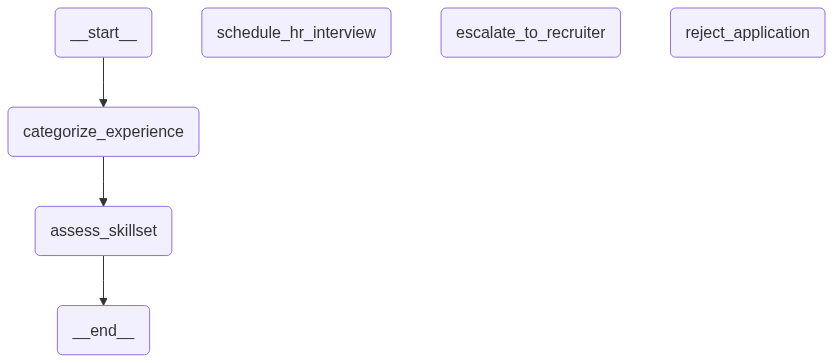

In [18]:
from IPython.display import Image, display

display(
    Image(
        app.get_graph().draw_mermaid_png()
    )
)

In [19]:
def run_candidate_screening(application: str):
  results = app.invoke({"application" : application})
  return {
      "experience_level" : results["experience_level"],
      "skill_match" : results["skill_match"],
      "response" : results["response"]
  }

In [20]:
application_text = "I have 10 years of experience in software engineering with expertise in JAVA"
results = run_candidate_screening(application_text)
print("\n\nComputed Results :")
print(f"Application: {application_text}")
print(f"Experience Level: {results['experience_level']}")
print(f"Skill Match: {results['skill_match']}")
print(f"Response: {results['response']}")


Categorizing the experience level of candidate : 
Experience Level : Senior-level

Assessing the skillset of candidate : 
Skill Match : No Match
Escalating to recruiter


Computed Results :
Application: I have 10 years of experience in software engineering with expertise in JAVA
Experience Level: Senior-level
Skill Match: No Match
Response: Candidate has senior-level experience but doesn't match job skills.


In [21]:
application_text = "I have 1 year of experience in software engineering with expertise in JAVA"
results = run_candidate_screening(application_text)
print("\n\nComputed Results :")
print(f"Application: {application_text}")
print(f"Experience Level: {results['experience_level']}")
print(f"Skill Match: {results['skill_match']}")
print(f"Response: {results['response']}")


Categorizing the experience level of candidate : 
Experience Level : Entry-level

Assessing the skillset of candidate : 
Skill Match : No Match
Sending rejecting email


Computed Results :
Application: I have 1 year of experience in software engineering with expertise in JAVA
Experience Level: Entry-level
Skill Match: No Match
Response: Candidate doesn't meet JD and has been rejected.


In [22]:
application_text = "I have experience in software engineering with expertise in Python"
results = run_candidate_screening(application_text)
print("\n\nComputed Results :")
print(f"Application: {application_text}")
print(f"Experience Level: {results['experience_level']}")
print(f"Skill Match: {results['skill_match']}")
print(f"Response: {results['response']}")


Categorizing the experience level of candidate : 
Experience Level : Based on the information provided in the job application, the candidate can be categorized as 'Mid-level'.

Assessing the skillset of candidate : 
Skill Match : Match

Scheduling the interview : 


Computed Results :
Application: I have experience in software engineering with expertise in Python
Experience Level: Based on the information provided in the job application, the candidate can be categorized as 'Mid-level'.
Skill Match: Match
Response: Candidate has been shortlisted for an HR interview.


In [23]:
application_text = "I have 5 years of experience in software engineering with expertise in C++"
results = run_candidate_screening(application_text)
print("\n\nComputed Results :")
print(f"Application: {application_text}")
print(f"Experience Level: {results['experience_level']}")
print(f"Skill Match: {results['skill_match']}")
print(f"Response: {results['response']}")


Categorizing the experience level of candidate : 
Experience Level : Mid-level

Assessing the skillset of candidate : 
Skill Match : No Match
Sending rejecting email


Computed Results :
Application: I have 5 years of experience in software engineering with expertise in C++
Experience Level: Mid-level
Skill Match: No Match
Response: Candidate doesn't meet JD and has been rejected.
